In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
import statsmodels.api as sm
from pygeocoder import Geocoder
import folium
from folium.plugins import HeatMap
import pyproj
import warnings
warnings.filterwarnings("ignore")

%pylab inline

C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


<h1 id="tocheading">Table of contents</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

pd.set_option('display.max_columns', None)

### Sensor locations

sensor_0 : RHI roof (at corner of Hicks and W 9th streets, elevation approx. 8m) - 767 Hicks St, Brooklyn, NY 11231

sensor_3 : RHI entrance (on Hicks street at street level) - 767 Hicks St, Brooklyn, NY 11231

sensor_2 : TechLab (at ground level) - 106 Ferris St

sensor_4 : PioneerWorks roof (elevation approx. 15m) - 159 Pioneer St, Brooklyn, NY 11231

In [4]:
# Find location of each sensor
sen0loc = Geocoder.geocode("767 Hicks St, Brooklyn, NY 11231")
sen2loc = Geocoder.geocode("106 Ferris St, Brooklyn, NY 11231")
sen3loc = Geocoder.geocode("767 Hicks St, Brooklyn, NY 11231")
sen4loc = Geocoder.geocode("159 Pioneer St, Brooklyn, NY 11231")

sen0loc = sen0loc.coordinates
sen2loc = sen2loc.coordinates
sen3loc = sen3loc.coordinates
sen4loc = sen4loc.coordinates

### Load data

We load the data from sensors, PLUTO, and 311 noise complaints and munge the data sets to extract information for further analysis.

#### Sensors

In [5]:
# Read sensor data
sens = pd.read_csv('Data\LuxDustNoise_summarized_4hour_0719.csv')

# Date transformation
sens['date'] = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sens.dt]

# Select individual sensor data
sens0 = sens[sens.sensor=='sensor_0']
sens2 = sens[sens.sensor=='sensor_2']
sens3 = sens[sens.sensor=='sensor_3']
sens4 = sens[sens.sensor=='sensor_4']

# Extract temporal information
sens['day']=[sens.date[i].day for i in range (len(sens))]
sens['month']=[sens.date[i].month for i in range (len(sens))]
sens['day_month'] = sens.month.astype(str) + '/' + sens.day.astype(str)

# Get average values from all 4 sensor indications
sensGr = sens.groupby('date', as_index=False).mean()

# Groupby average daily indications
sensGrDay = sens.groupby('day_month',as_index=False).mean()

# Define a time interval to match the frequency of the data
start = datetime.datetime.strptime("21-06-2016", "%d-%m-%Y")
end = datetime.datetime.strptime("12-07-2016", "%d-%m-%Y")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

sensGrDay['day'] = date_generated

In [6]:
# Group daily values for each individual sensor (similar as above)
sens0['date'] = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sens0.dt]
sens2['date'] = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sens2.dt]
sens3['date'] = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sens3.dt]
sens4['date'] = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sens4.dt]

sens0.reset_index(inplace=True)
sens0 = sens0.drop('index',axis=1)
sens2.reset_index(inplace=True)
sens2 = sens2.drop('index',axis=1)
sens3.reset_index(inplace=True)
sens3 = sens3.drop('index',axis=1)
sens4.reset_index(inplace=True)
sens4 = sens4.drop('index',axis=1)

sens0['day']=[sens0.date[i].day for i in range (len(sens0))]
sens0['month']=[sens0.date[i].month for i in range (len(sens0))]
sens0['day_month'] = sens0.month.astype(str) + '/' + sens0.day.astype(str)

sens2['day']=[sens2.date[i].day for i in range (len(sens2))]
sens2['month']=[sens2.date[i].month for i in range (len(sens2))]
sens2['day_month'] = sens2.month.astype(str) + '/' + sens2.day.astype(str)

sens3['day']=[sens3.date[i].day for i in range (len(sens3))]
sens3['month']=[sens3.date[i].month for i in range (len(sens3))]
sens3['day_month'] = sens3.month.astype(str) + '/' + sens3.day.astype(str)

sens4['day']=[sens4.date[i].day for i in range (len(sens4))]
sens4['month']=[sens4.date[i].month for i in range (len(sens4))]
sens4['day_month'] = sens4.month.astype(str) + '/' + sens4.day.astype(str)

sens0Gr = sens0.groupby('date', as_index=False).mean()
sens2Gr = sens2.groupby('date', as_index=False).mean()
sens3Gr = sens3.groupby('date', as_index=False).mean()
sens4Gr = sens4.groupby('date', as_index=False).mean()

sens0GrDay = sens0.groupby('day_month',as_index=False).mean()
sens2GrDay = sens2.groupby('day_month',as_index=False).mean()
sens3GrDay = sens3.groupby('day_month',as_index=False).mean()
sens4GrDay = sens4.groupby('day_month',as_index=False).mean()

start = datetime.datetime.strptime("21-06-2016", "%d-%m-%Y")
end = datetime.datetime.strptime("12-07-2016", "%d-%m-%Y")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

sens0GrDay['day'] = date_generated
sens2GrDay['day'] = date_generated
sens3GrDay['day'] = date_generated
sens4GrDay['day'] = date_generated

#### PLUTO

In [7]:
# Read 2016 PLUTO data for Brooklyn borough
# Data retrieved from: https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
pluto = pd.read_csv('Data\plutoBK.csv')

# Select Red Hook zip code
pluto = pluto[pluto.ZipCode == 11231.0]

# Transform location to lat/lon
lat=[]
lon=[]
NYSP1983 = pyproj.Proj(init="ESRI:102718", preserve_units=True)
for i in pluto.index:
    x, y = (pluto.XCoord[i], pluto.YCoord[i])
    lat.append(NYSP1983(x, y, inverse=True)[0])
    lon.append(NYSP1983(x, y, inverse=True)[1])

pluto['lat'] = lat
pluto['lon'] = lon

def find_zoning(x):
    """
    Extracts the zoning of a property
    1: Residential
    2: Commercial
    3: Manufacturing
    4: Other
    """
    if x[0] == 'R':
        val = 1
    elif x[0] == 'C':
        val = 2
    elif x[0] == 'M':
        val = 3
    else:
        val = 4
    return val

# Find zoning type
pluto['zone'] = pluto['ZoneDist1'].apply(find_zoning)

# Try to establish a zoning index for better mapping (didn't work)
#pluto['zoneIdx'] = pluto['UnitsTotal'] * pluto['zone']

#### 311 noise complaints

In [8]:
# Read noise related 311 complaints
# Data retrieved from: https://data.cityofnewyork.us/Social-Services/Noise-SRs-since-20151101/fqi4-uxkk
com311 = pd.read_csv('Data/Noise_SRs_since_20151101.csv')

# Select Red Hook zipcode
com311 = com311[com311['Incident Zip'] == 11231.0]
com311.reset_index(inplace=True)
com311 = com311.drop('index',axis=1)

# Convert date
date=[]
for i in range(len(com311)):
    try:
        date.append(dt.datetime.strptime(com311['Created Date'][i], '%m/%d/%Y %H:%M:%S PM'))
    except:
        date.append(dt.datetime.strptime(com311['Created Date'][i], '%m/%d/%Y %H:%M:%S AM'))
com311['date'] = date

# Select dates that match sensor data period
com311 = com311[(com311.date>sens.date[0])&(com311.date<sens.date[len(sens)-1])]

# Select variables of interest
com311 = com311[['Incident Address', 'Street Name', 'Location', 'date']]

com311['counter'] = np.ones(len(com311))

com311.reset_index(inplace=True)
com311 = com311.drop('index',axis=1)

# Extract temporal information
com311['day']=[com311.date[i].day for i in range (len(com311))]
com311['month']=[com311.date[i].month for i in range (len(com311))]
com311['hour']=[com311.date[i].hour for i in range (len(com311))]
com311['day_month'] = com311.month.astype(str) + '/' + com311.day.astype(str)

# Get daily aggregate 311 complaints
gr311 = com311.groupby('day_month', as_index=False).sum()

# Append 6/22 in the data sets where no complaints occurred
gr311.loc[20] = np.array(['6/22', 0,0,0,0])
gr311.counter[20] = int(gr311.counter[20])

#### Weather

In [9]:
# Data retrieved from: 
# https://www.wunderground.com/history/airport/KJFK/2016/6/21/CustomHistory.html?dayend=11&monthend=7&yearend=2016&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&MR=1
weathData = pd.read_csv('Data\weather_data.csv')

### Individual sensor distributions

We plot the distributions of each individual sensor for all environmental variables (i.e. luminosity, particulate concentration and noise levels). We observe skewed distributions, with only noise levels approximating somewhat the normal distribution. Particulate concentration shows extreme values, indication of anomalies in certain periods of time.

#### Sensor 0

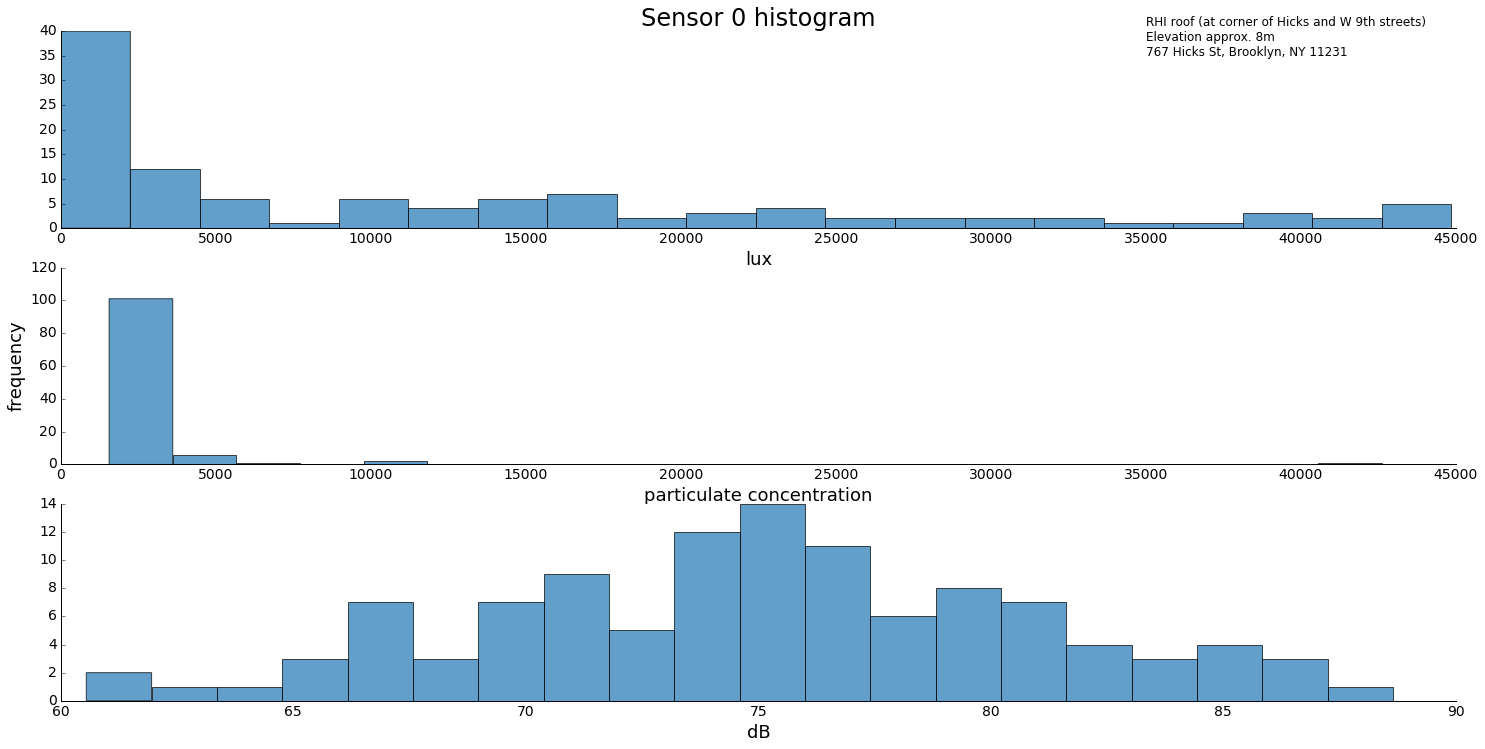

In [10]:
plt.figure(figsize=(25,12))
plt.subplot(311)
plt.hist(sens0.lux, alpha=0.7 ,bins=20)
plt.text(35000, 35,'RHI roof (at corner of Hicks and W 9th streets) \nElevation approx. 8m \n767 Hicks St, Brooklyn, NY 11231',
         fontsize=12)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.xlabel('lux')
plt.title('Sensor 0 histogram', size=24)
plt.subplot(312)
plt.hist(sens0.con, alpha=0.7,bins=20)
plt.xlabel('particulate concentration')
plt.ylabel('frequency')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(313)
plt.hist(sens0.spl, alpha=0.7,bins=20)
plt.xlabel('dB')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.show()

#### Sensor 2

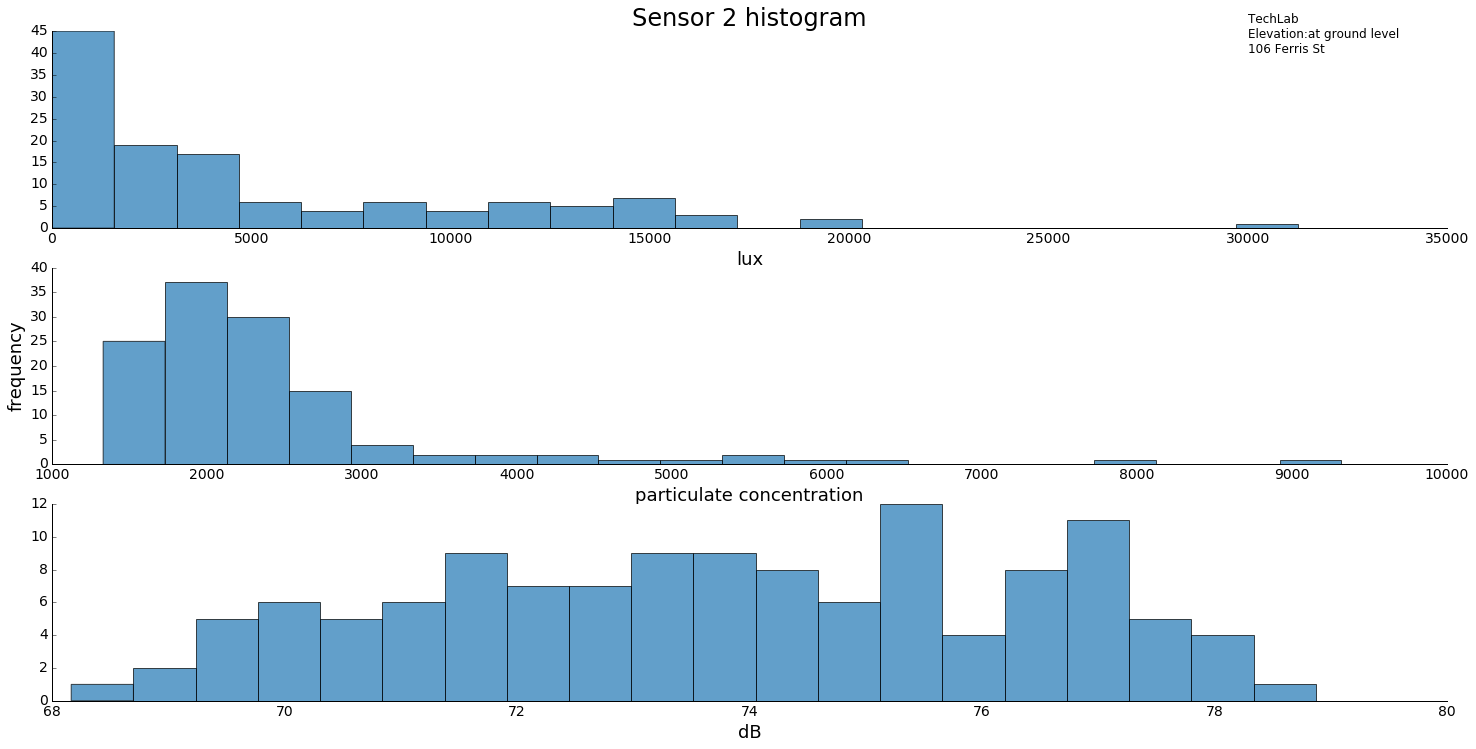

In [11]:
plt.figure(figsize=(25,12))
plt.subplot(311)
plt.hist(sens2.lux, alpha=0.7 ,bins=20)
plt.text(30000, 40,'TechLab \nElevation:at ground level \n106 Ferris St',
         fontsize=12)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.xlabel('lux')
plt.title('Sensor 2 histogram', size=24)
plt.subplot(312)
plt.hist(sens2.con, alpha=0.7,bins=20)
plt.xlabel('particulate concentration')
plt.ylabel('frequency')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(313)
plt.hist(sens2.spl, alpha=0.7,bins=20)
plt.xlabel('dB')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.show()

#### Sensor 3

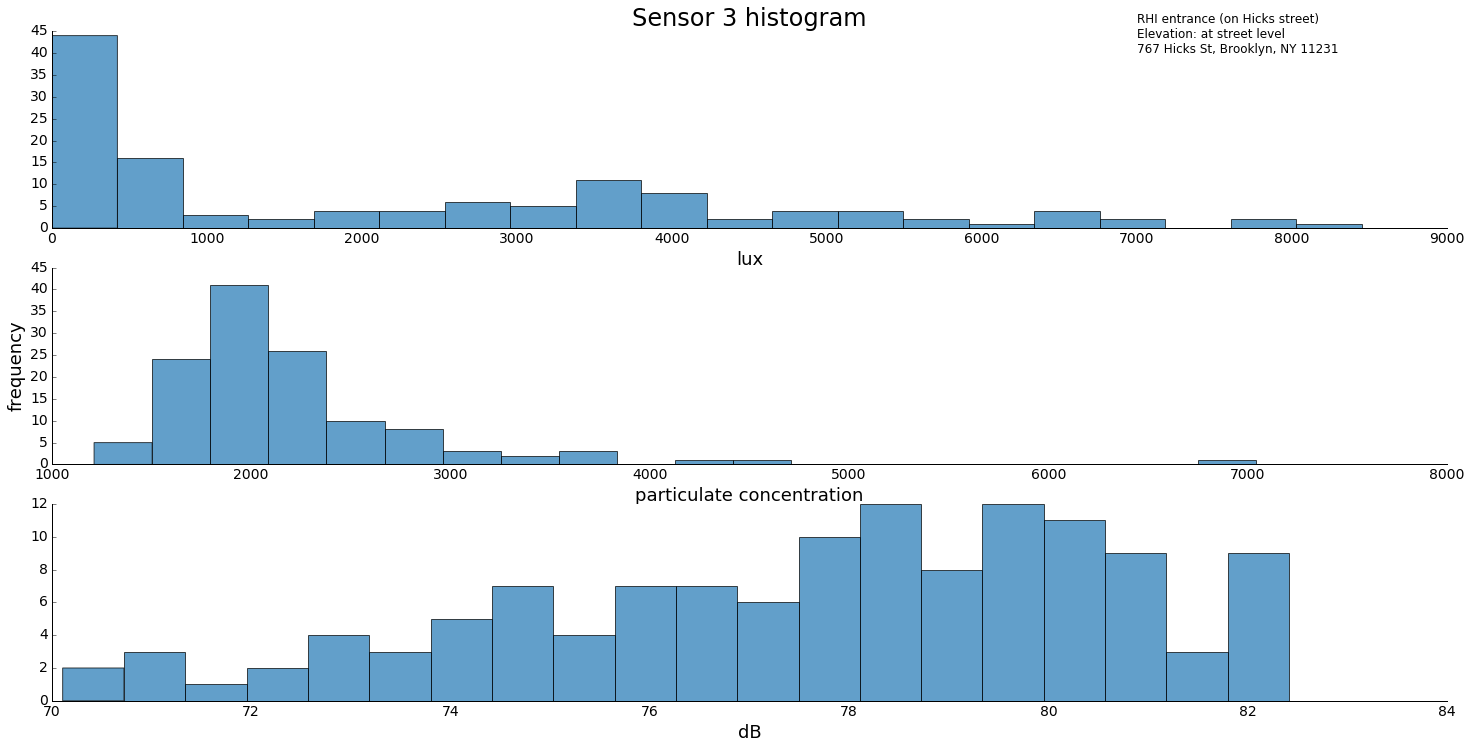

In [12]:
plt.figure(figsize=(25,12))
plt.subplot(311)
plt.hist(sens3.lux, alpha=0.7 ,bins=20)
plt.text(7000, 40,'RHI entrance (on Hicks street) \nElevation: at street level \n767 Hicks St, Brooklyn, NY 11231',
         fontsize=12)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.xlabel('lux')
plt.title('Sensor 3 histogram', size=24)
plt.subplot(312)
plt.hist(sens3.con, alpha=0.7,bins=20)
plt.xlabel('particulate concentration')
plt.ylabel('frequency')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(313)
plt.hist(sens3.spl, alpha=0.7,bins=20)
plt.xlabel('dB')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.show()

#### Sensor 4

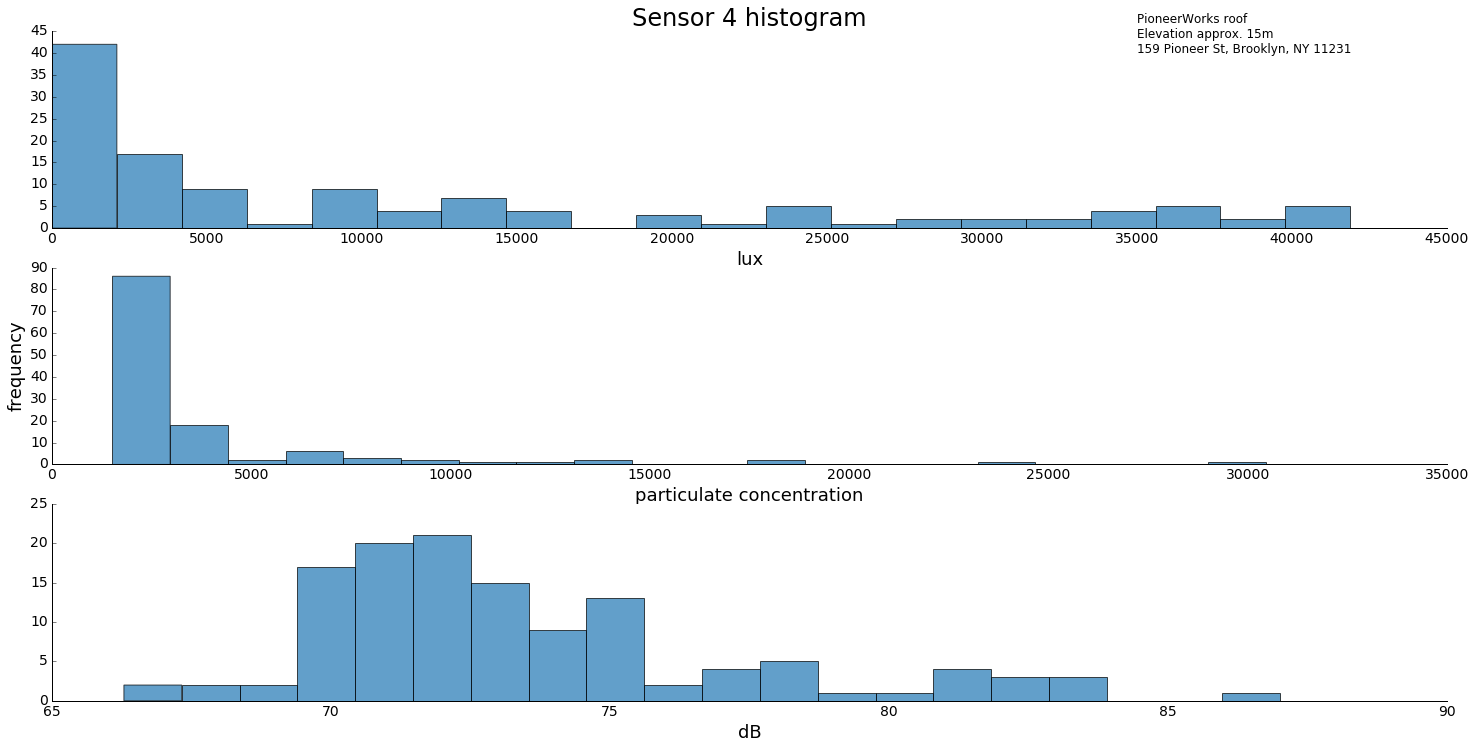

In [13]:
plt.figure(figsize=(25,12))
plt.subplot(311)
plt.hist(sens4.lux, alpha=0.7 ,bins=20)
plt.text(35000, 40,'PioneerWorks roof \nElevation approx. 15m \n159 Pioneer St, Brooklyn, NY 11231',
         fontsize=12)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.xlabel('lux')
plt.title('Sensor 4 histogram', size=24)
plt.subplot(312)
plt.hist(sens4.con, alpha=0.7,bins=20)
plt.xlabel('particulate concentration')
plt.ylabel('frequency')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(313)
plt.hist(sens4.spl, alpha=0.7,bins=20)
plt.xlabel('dB')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.show()

### Anomaly detection in sensor data

In this section we plot the sensor data time series and observe anomalous behavior. We use an approach based on median absolute deviation and successfully manage to capture outlier in the data (unlike with standard approaches, such as two standard deviation thresholds from the mean).

In [14]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    val=[]
    for i in range(len(modified_z_score)):
        if modified_z_score[i] > thresh:
            val.append(1)
        else: 
            val.append(0)
    return val

In [15]:
# Flag anomalous behavior
sensGr['outlier_con'] = is_outlier(sensGr.con)

# Remove outliers for further analysis
sensClean = sensGr[sensGr.outlier_con==0]
sensClean.reset_index(inplace=True)
sensClean = sensClean.drop('index',axis=1)

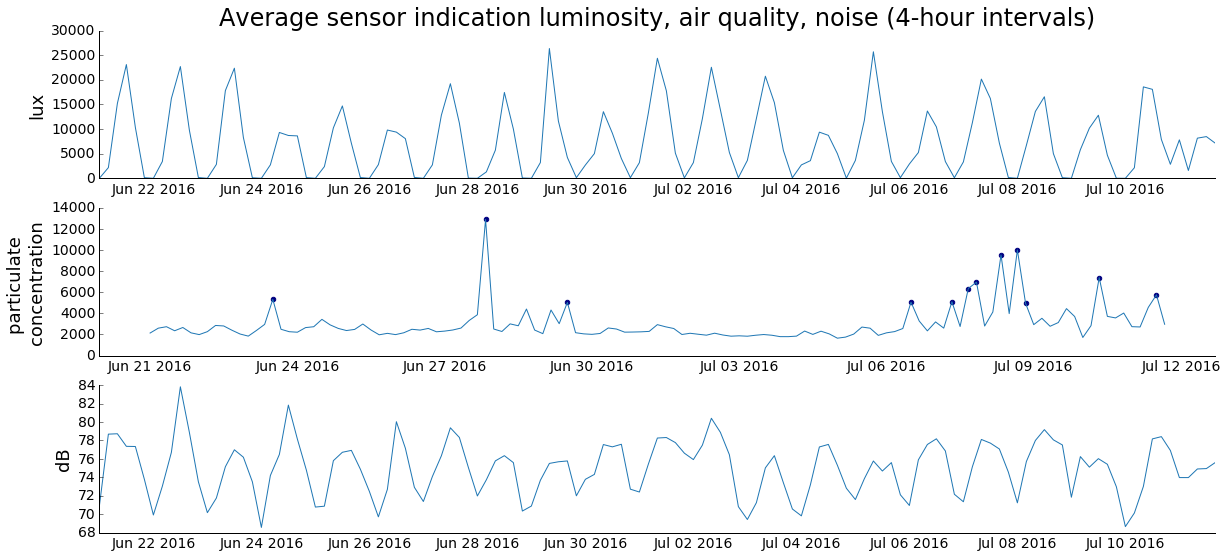

In [16]:
plt.figure(figsize=(20,9))
plt.subplot(311)
plt.plot(sensGr.date, sensGr.lux)
plt.ylabel('lux')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.title('Average sensor indication luminosity, air quality, noise (4-hour intervals)', size=24)
plt.subplot(312)
plt.plot(sensGr.date, sensGr.con)
for i in range(len(sensGr)):
    if sensGr['outlier_con'][i]==1:
        plt.scatter(sensGr.date[i], sensGr.con[i], color='navy')
plt.ylabel('particulate \nconcentration')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(313)
plt.plot(sensGr.date, sensGr.spl)
plt.ylabel('dB')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.show()

**We observe several anomalies in the air quality data. Certain peaks occur in individual days, and a series of anomalous behavior happens between July 6th and 12th.**

In [17]:
sens0.con.mean()

3185.438356821172

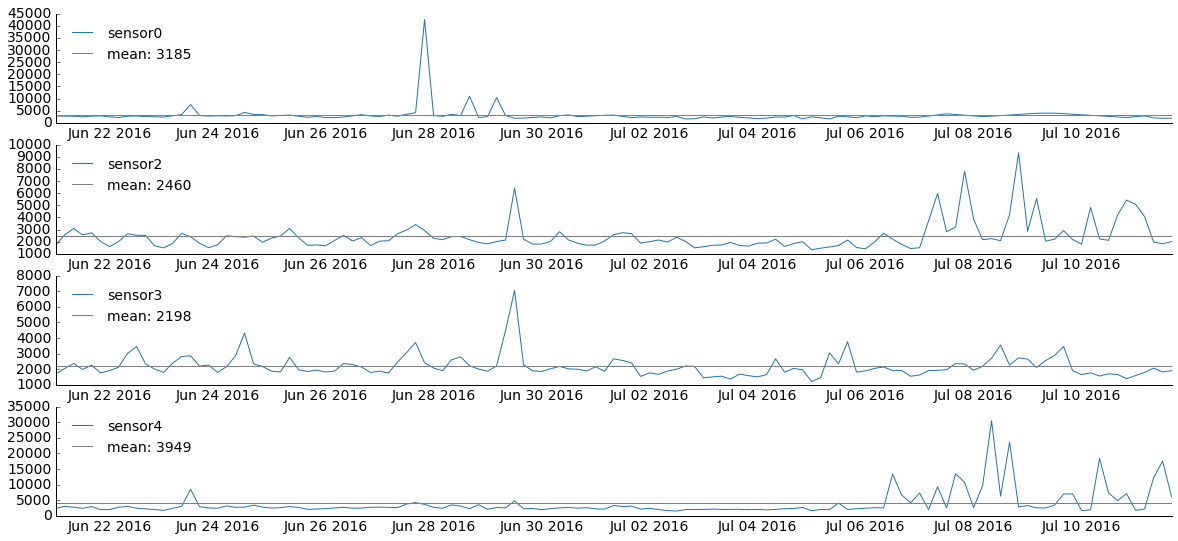

In [18]:
plt.figure(figsize=(20,9))
plt.subplot(411)
plt.plot(sens0.date, sens0.con,label='sensor0')
plt.axhline(y=sens0.con.mean(), color='gray',label='mean: %d' %sens0.con.mean())
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.legend(loc=2)
plt.subplot(412)
plt.plot(sens2.date, sens2.con,label='sensor2')
plt.axhline(y=sens2.con.mean(), color='gray',label='mean: %d' %sens2.con.mean())
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.legend(loc=2)
plt.subplot(413)
plt.plot(sens3.date, sens3.con,label='sensor3')
plt.axhline(y=sens3.con.mean(), color='gray',label='mean: %d' %sens3.con.mean())
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.legend(loc=2)
plt.subplot(414)
plt.plot(sens4.date, sens4.con,label='sensor4')
plt.axhline(y=sens4.con.mean(), color='gray',label='mean: %d' %sens4.con.mean())
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.legend(loc=2)
plt.show()

**Breaking down the air quality indications into individual sensors, we notice a spike in sensor0 in June 28th, accompanied by smaller spikes in the other sensors in the same period. Similarly, in June 30th sensors 2 and 3 show a peak. Interestingly, both sensors are located in street level, and sensors located in higher elevation didnt capture the effect. Thus, sensor deployment strategy must be a multi-dimensional problem, to holistically cover a space of interest.**

**Moreover, both sensors 2 and 4 capture anomalies between July 6th and 12th. Both are located in the East side of Red Hook, that as can be seen in the following map, is mostly covered by industrial buildings according to PLUTO zoning information.**

** Grey lines in all plots represent the mean value of the sensor indication. In general, lower elevation points realize better air quality on average (sensors 2 and 3). Additionally, sensors located in majorly residential areas (sensors 0 and 3) show lower particulate concentrations compared to industrial ones in both low and higher elevations.**

### Sensor and land use mapping

In [19]:
rhManu = pluto[pluto.zone == 3]
rhRes = pluto[pluto.zone == 1]

redhook_coor = (40.6773, -74.0094)

m = folium.Map(location=redhook_coor, tiles='stamentoner', zoom_start=16)
m.add_children(HeatMap(zip(rhRes.lon, rhRes.lat, rhRes.zone), radius=10, gradient={.5: 'blue'})) # Residential (blue)
m.add_children(HeatMap(zip(rhManu.lon, rhManu.lat, rhManu.zone), radius=10,gradient={.5: 'red'})) # Manufacturing (red)
marker_cluster = folium.MarkerCluster().add_to(m)

sens_details = ['Sensor0 - 767 Hicks St - Elevation: approx. 8m',
                'Sensor2 - 106 Ferris St - Elevation: ground level',
                'Sensor3 - 767 Hicks St - Elevation: street level',
                'Sensor4 - 159 Pioneer St - Elevation: approx. 15m']
for i,j in enumerate([sen0loc, sen2loc, sen3loc, sen4loc]):
    folium.Marker(
        location=[j[0], j[1]],
        popup = sens_details[i],
        #popup='Sensor' + str(i+1),
        icon=folium.Icon(color='green', icon='ok-sign'),).add_to(marker_cluster)
m

**The heatmap above shows the distribution of residential (blue) and industrial (red) properties in Red Hook area, dased on Kernell density estimation, as well as the sensor locations (green markers). It is evident that as we move west of Van Brunt St more residential properties appear. An effect we tried to capture but werent able in the current map is the residential intensity. For example, the area west of Coffey Park is covered by a huge residential property with various units. However, in PLUTO data this is reported as a single property.**

** As mentioned above, sensors 2 and 4 are located in a majorly industrial area, while sensors 0 and 3 capture a rather residential part of the neighborhood.**

### Outlier-free data time series and distribution plots

After removing the outliers from the data, we plot them along with their distributions. We notice a strong daily pattern and a consistant behavior, especially in luminosity and noise indications. However, particulate concentration shows fluctuations above and below the overall mean during certain dates, which can be attributed to external factors.

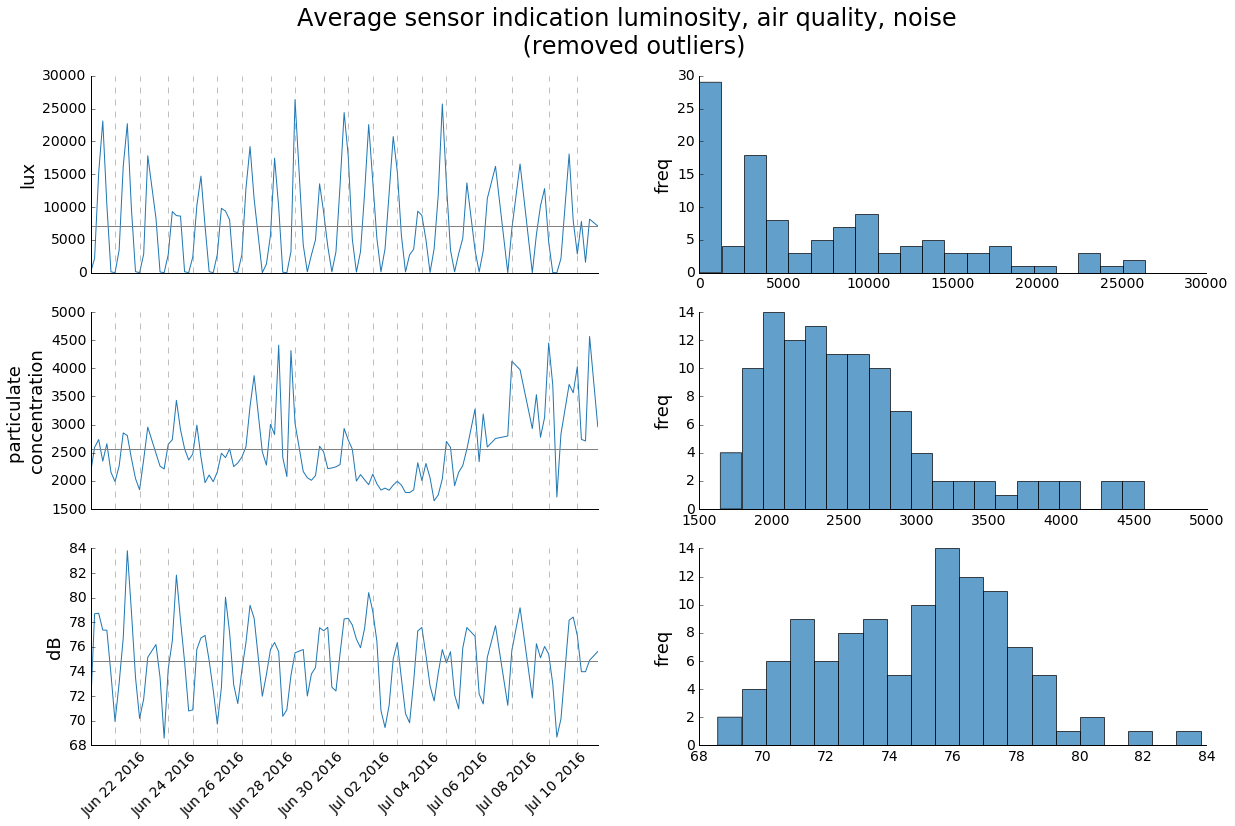

In [20]:
plt.figure(figsize=(20,12))
plt.suptitle('Average sensor indication luminosity, air quality, noise \n (removed outliers)', size=24)
plt.subplot(321)
plt.plot(sensClean.date, sensClean.lux)
plt.axhline(y=sensClean.lux.mean(), color='gray')
for i in range(6,len(sensClean),6):
    plt.axvline(x=sensClean.date[i],linestyle='--',color='gray',alpha=0.5)
plt.xticks([])
plt.ylabel('lux')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(322)
plt.hist(sensClean.lux,bins=20,alpha=0.7)
plt.ylabel('freq')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(323)
plt.plot(sensClean.date, sensClean.con)
plt.axhline(y=sensClean.con.mean(), color='gray')
for i in range(6,len(sensClean),6):
    plt.axvline(x=sensClean.date[i],linestyle='--',color='gray',alpha=0.5)
plt.xticks([])
plt.ylabel('particulate \nconcentration')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(324)
plt.hist(sensClean.con,bins=20,alpha=0.7)
plt.ylabel('freq')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(325)
plt.plot(sensClean.date, sensClean.spl)
plt.axhline(y=sensClean.spl.mean(), color='gray')
for i in range(6,len(sensClean),6):
    plt.axvline(x=sensClean.date[i],linestyle='--',color='gray',alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('dB')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(326)
plt.hist(sensClean.spl,bins=20,alpha=0.7)
plt.ylabel('freq')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.show()

### Daily averages of air quality, temperature, humidity and wind speed

Since air quality is the variable that shows fluctuations over time, we focus the following section on understanding factors that might affect it. In the following plots we try to identify correlations between air quality and environmental variables. We show the average daily value of all sensors, as well as environmental indicators from NYC records.

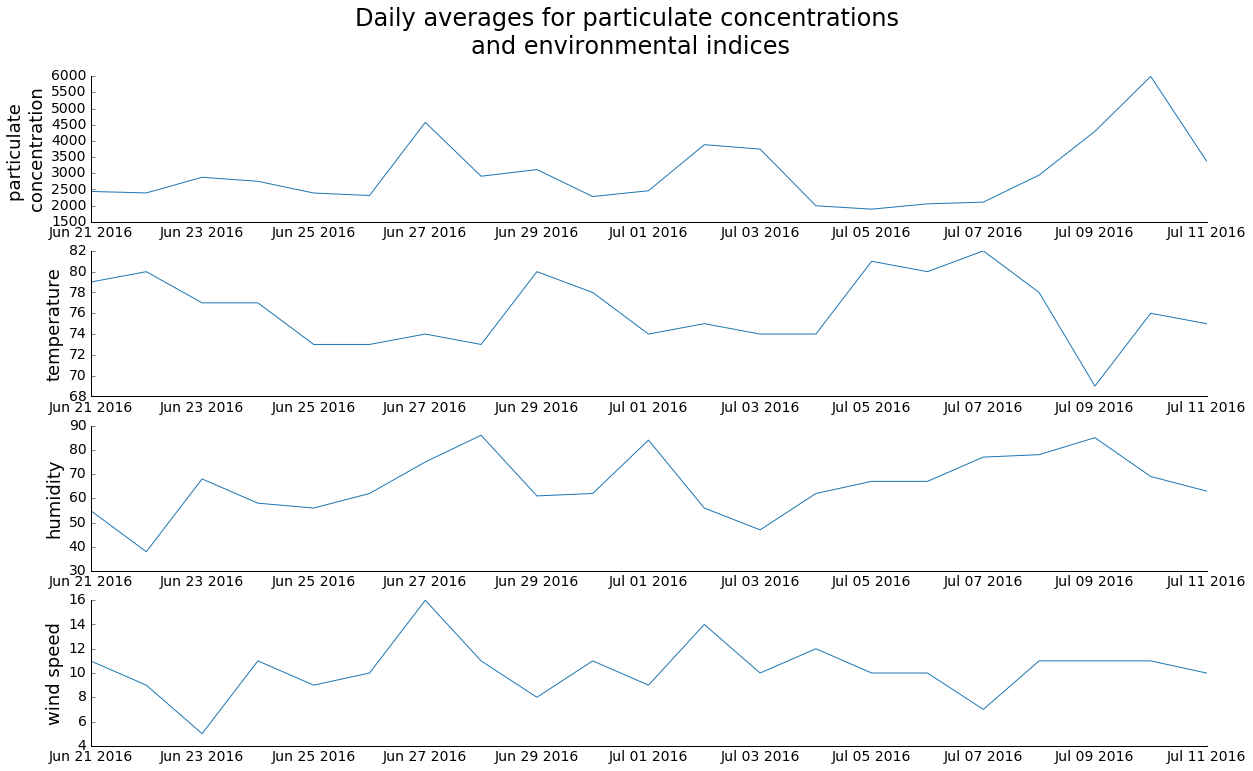

In [21]:
plt.figure(figsize=(20,12))
plt.suptitle('Daily averages for particulate concentrations \nand environmental indices',size=24)
plt.subplot(411)
plt.plot(sensGrDay.day, sensGrDay.con)
plt.ylabel('particulate \nconcentration')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(412)
plt.plot(sensGrDay.day, weathData.avgTemp)
plt.ylabel('temperature')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(413)
plt.plot(sensGrDay.day, weathData.avgHumid)
plt.ylabel('humidity')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(414)
plt.plot(sensGrDay.day, weathData.avgWind)
plt.ylabel('wind speed')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.show()

** A first look in the plot above shows a correlation between temperature and particulate concentration levels. Specifically, we notice that peaks in temperature, are related with future peaks in particulate concentration. To get a more statistical insight in the relationship among the features, following we compute their cross-correlation.**

In [22]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [23]:
# Compute cross-correlation between air quality and environmental variables
xcovWeekTemp= [crosscorr(sensGrDay.con, weathData.avgTemp, lag=i) for i in range(7)]
xcovWeekHumid= [crosscorr(sensGrDay.con, weathData.avgHumid, lag=i) for i in range(7)]
xcovWeekWind= [crosscorr(sensGrDay.con, weathData.avgWind, lag=i) for i in range(7)]

### Cross-correlation of air quality and environmental indicators

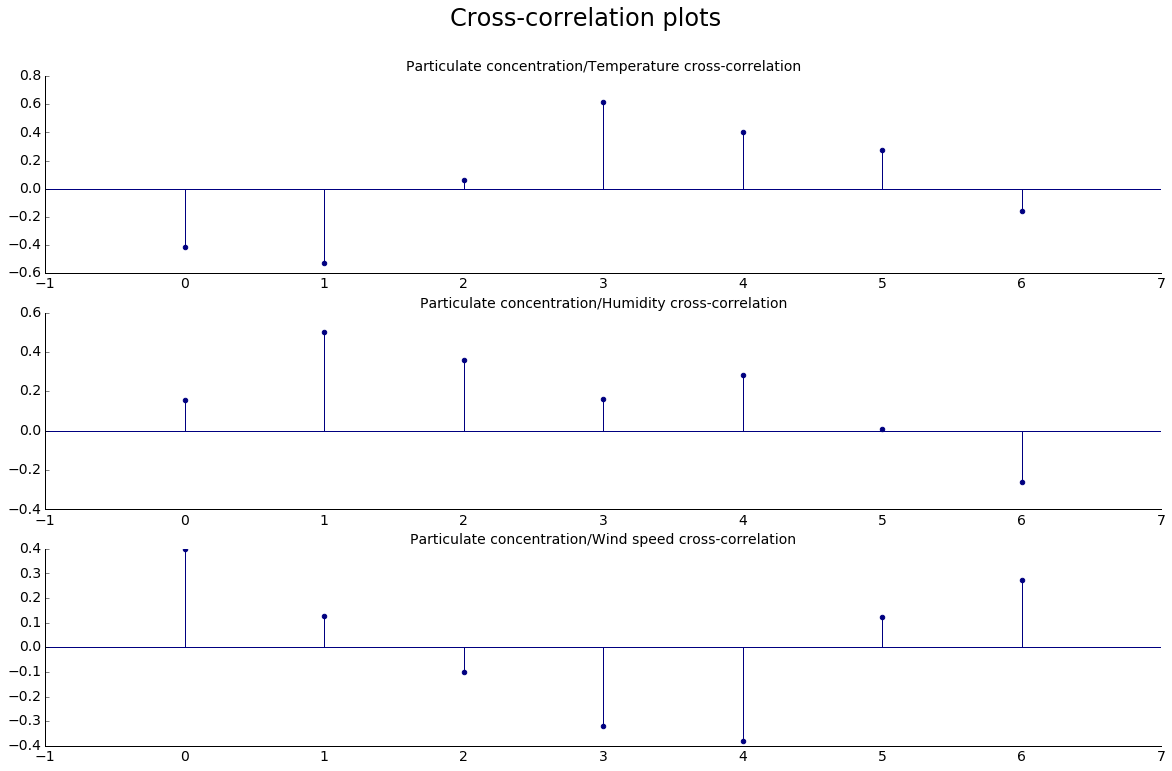

In [24]:
plt.figure(figsize=(20,12))
plt.suptitle('Cross-correlation plots',size=24)
plt.subplot(311)
plt.axhline(y=0,color='navy')
for i in range(len(xcovWeekTemp)):
    plt.scatter(i, xcovWeekTemp[i],color='navy')
    plt.axvline(i, 0.6/1.4,(0.6+xcovWeekTemp[i])/1.4,color='navy')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.title('Particulate concentration/Temperature cross-correlation',size=14)
plt.subplot(312)
plt.axhline(y=0,color='navy')
for i in range(len(xcovWeekHumid)):
    plt.scatter(i, xcovWeekHumid[i],color='navy')
    plt.axvline(i, 0.4/1.0,(0.4+xcovWeekHumid[i])/1.0,color='navy')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.title('Particulate concentration/Humidity cross-correlation',size=14)
plt.subplot(313)
plt.axhline(y=0,color='navy')
plt.ylim(-0.4,0.4)
for i in range(len(xcovWeekWind)):
    plt.scatter(i, xcovWeekWind[i],color='navy')
    plt.axvline(i, 0.4/0.8,(0.4+xcovWeekWind[i])/0.8,color='navy')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.title('Particulate concentration/Wind speed cross-correlation',size=14)
plt.show()

** The day-to-day cross-correlation plots confirm the pattern observed earlier. Particulate concentration appers to be positively related with the temperature 3 days earlier, last day humidity and current wind speed.**

** Nevertheless, we should be cautious for the findings above and they cannot be conclusive for two main reasons. First, temperature, humidity and wind speed come from JFK airport, and do not fully represent the specific area of Red Hook. Secondly, the sampling period is not long enough to reach accurate conclusions about the relationship between the aforementioned variables. **

### Noise level relation to 311 complaints

In the last part of the analysis we examine whether there is any correlation between measured noise levels and noise-related 311 complaints. 

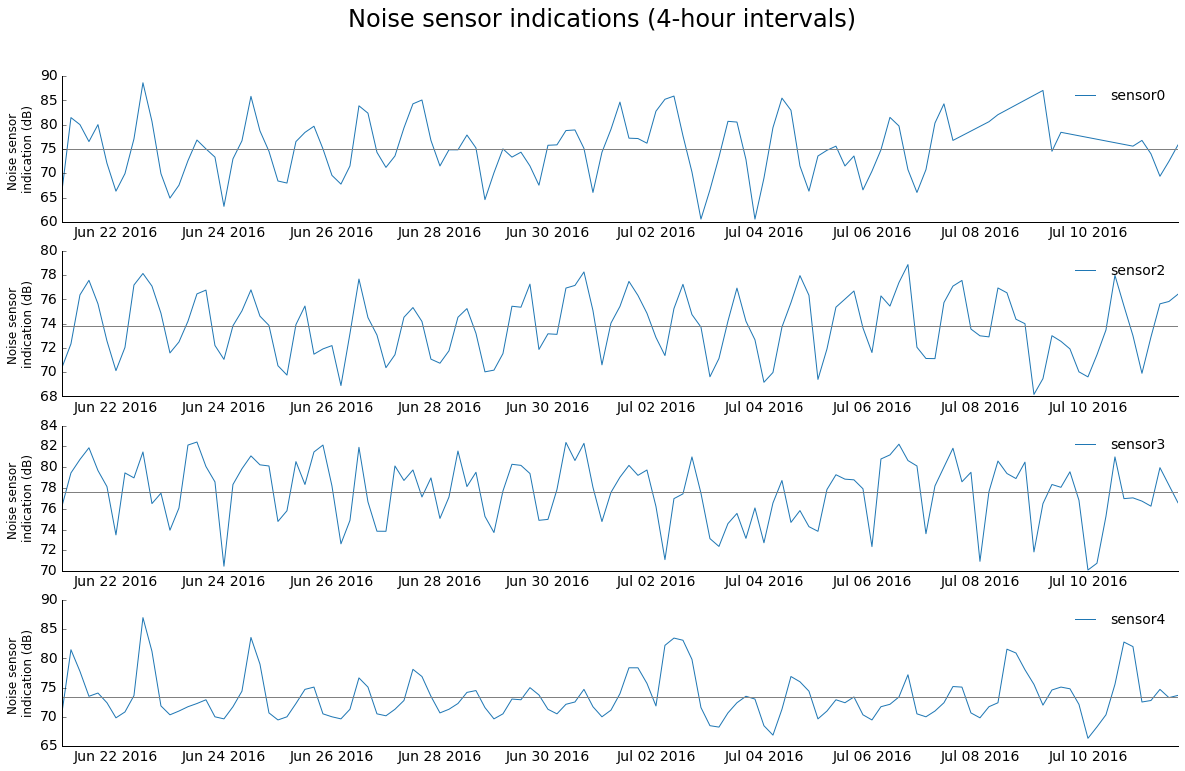

In [25]:
plt.figure(figsize=(20,12))
plt.suptitle('Noise sensor indications (4-hour intervals)',size=24)
plt.subplot(411)
plt.plot(sens0.date, sens0.spl,label='sensor0')
plt.axhline(y=sens0.spl.mean(),color='gray')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.ylabel('Noise sensor \nindication (dB)',size=12)
plt.legend(loc=1)
plt.subplot(412)
plt.plot(sens2.date, sens2.spl,label='sensor2')
plt.axhline(y=sens2.spl.mean(),color='gray')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.ylabel('Noise sensor \nindication (dB)',size=12)
plt.legend(loc=1)
plt.subplot(413)
plt.plot(sens3.date, sens3.spl,label='sensor3')
plt.axhline(y=sens3.spl.mean(),color='gray')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.ylabel('Noise sensor \nindication (dB)',size=12)
plt.legend(loc=1)
plt.subplot(414)
plt.plot(sens4.date, sens4.spl,label='sensor4')
plt.axhline(y=sens4.spl.mean(),color='gray')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.ylabel('Noise sensor \nindication (dB)',size=12)
plt.legend(loc=1)
plt.show()

** What we show in the plots above is the noise sensors' indications on 4-hour measurement intervals. We observe a daily pattern, with noise peaking during mornings. The small deviations from the data mean do not suggest any anomaly, that would justify increase in the noise-related 311 complaints.**

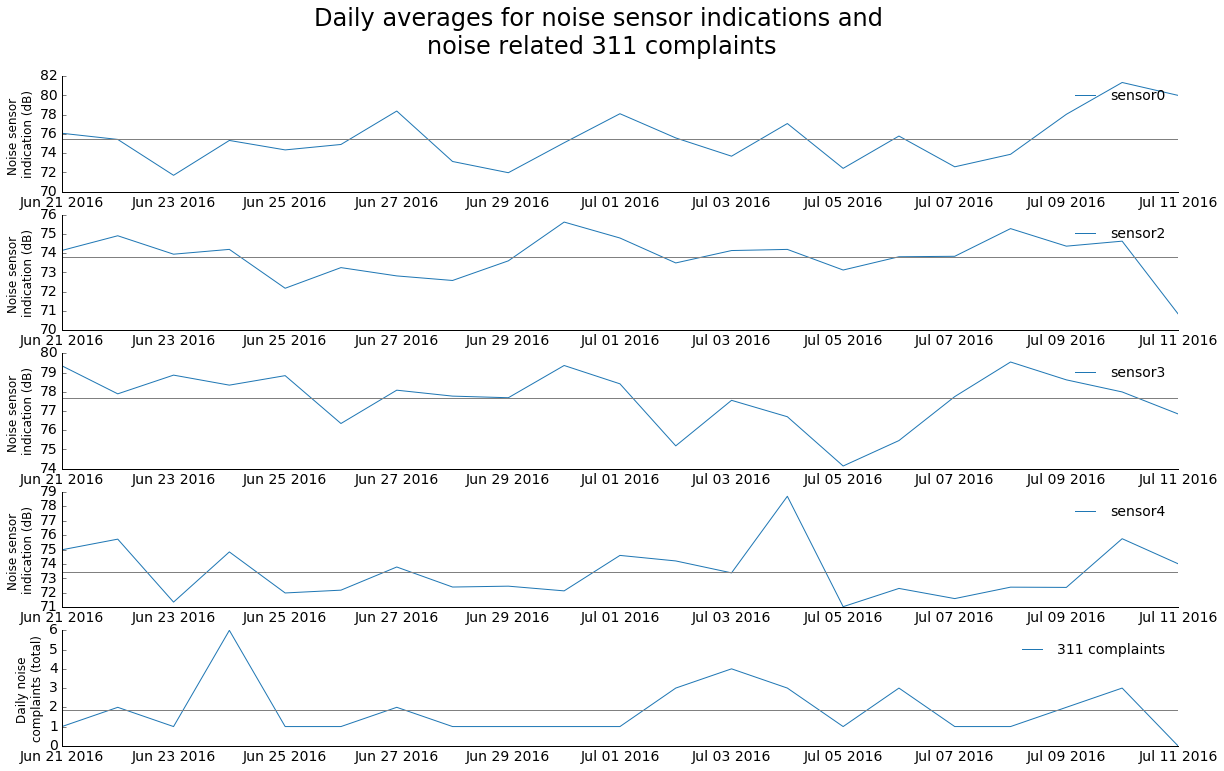

In [26]:
plt.figure(figsize=(20,12))
plt.suptitle('Daily averages for noise sensor indications and \nnoise related 311 complaints',size=24)
plt.subplot(511)
plt.plot(sens0GrDay.day, sens0GrDay.spl,label='sensor0')
plt.axhline(y=sens0GrDay.spl.mean(),color='gray')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.ylabel('Noise sensor \nindication (dB)',size=12)
plt.legend(loc=1)
plt.subplot(512)
plt.plot(sens2GrDay.day, sens2GrDay.spl,label='sensor2')
plt.axhline(y=sens2GrDay.spl.mean(),color='gray')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.ylabel('Noise sensor \nindication (dB)',size=12)
plt.legend(loc=1)
plt.subplot(513)
plt.plot(sens3GrDay.day, sens3GrDay.spl,label='sensor3')
plt.axhline(y=sens3GrDay.spl.mean(),color='gray')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.ylabel('Noise sensor \nindication (dB)',size=12)
plt.legend(loc=1)
plt.subplot(514)
plt.plot(sens4GrDay.day, sens4GrDay.spl,label='sensor4')
plt.axhline(y=sens4GrDay.spl.mean(),color='gray')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.ylabel('Noise sensor \nindication (dB)',size=12)
plt.legend(loc=1)
plt.subplot(515)
plt.plot(date_generated,gr311.counter, label='311 complaints')
plt.axhline(y=gr311.counter.mean(),color='gray')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.ylabel('Daily noise \ncomplaints (total)',size=12)
plt.legend(loc=1)
plt.show()

** To further assess potential relationships between noise levels and noise-related complaints in Red Hook area, we plot the daily average sensor indications along with the total reported noise-related 311 complaints. We see than on June 24th the 311 complaints are more than double compared to the average, however the sensors' indications do not capture an extreme event, neither at this day nor in the previous one (lagged effect on reporting).**

** This weak relation between noise levels and 311 complaints suggest that noise complaints are potentially based on discrete events, rather than a continuous noisy pattern that can be captured by the sensors. **

** The findings presented above are not conclusive for various reasons. First, we isolated 311 complaints for the whole zip-code of Rer Hook, while the sensors cover the area partially. Also, even though we extended the 311 complaint coverage area to zip-code level, we notice that the average daily complaints are not more than 2, a sample quite small for inference.**

### Conclusion

In this work we analyze sensor measurements of air quality, luminosity and noise, identify patterns/anomalies and attempt to establish correlations with the urban environment, noise complaints and environmental conditions. 

We shown that land use and environmental variables, such as temperature and humidity can be correlated with air quality in an urban area. On the other hand, noise related complaints did not seem to correlate with the overall noise levels of the area.

The results can be further verified using more granular and localized data to compare with the sensor indications, however we provide an initial approach to understand the underlying patterns behind environmental sensing.